# Dynamische Generierung einer an das Regelwerk angepassten "openthesaurus.json"-Datei

In [16]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
openthesaurus_path = '../data/openthesaurus.txt'
regelwerk_path = '../data/regelbasierte_suche.json'
output_json_path = '../results/openthesaurus_processed.json'

# Regelwerk laden
with open(regelwerk_path, 'r', encoding='utf-8') as f:
    regelwerk = json.load(f)

# Merkmale und ihre positiven/negativen Attribute aus dem Regelwerk
merkmale = regelwerk["merkmale"]
hilfsmerkmale = regelwerk["hilfsmerkmale"]

# Wörterbuch zur Speicherung der Kategorien und ihrer Wörter mit Attributen
output_data = defaultdict(lambda: defaultdict(dict))

Hilfsfunktionen zur Erstellung von "openthesaurus_processed.json"

In [30]:
################################################################################
### Muss noch ausgebaut werden! Hier werden Zahlen (Datum, Uhrzeit) erfasst. ###
################################################################################

# "Uhrzeit" existiert bereits schon als Attribut in Thesaurus!
def is_dynamic_attribute(word, attribute):
    """
    Prüft, ob ein Wort einem dynamischen Merkmal wie 'Uhrzeit' entspricht.
    """
    if attribute == "HH:MM":
        return bool(re.match(r'^\d{1,2}:\d{2}$', word))
    return False

In [31]:
def parse_line(line):
    """
    Extrahieren von Wörtern und (Attributen) aus einer Zeile
    """
    parts = [part.strip() for part in line.split(';')]
    word_attributes = []

    for part in parts:
        # Suche nach Attributen in Klammern
        match = re.search(r'\((.*?)\)', part)
        if match:
            # Falls Attribute gefunden werden, speichere diese und entferne die Klammern
            attributes = [attr.strip() for attr in match.group(1).split(',')]
            word = re.sub(r'\(.*?\)', '', part).strip()
        else:
            word = part.strip()
            attributes = []

        word_attributes.append((word, attributes))
    
    return word_attributes

"openthesaurus_processed.json": Zuordnung von Wörtern in die entsprechenden Merkmalskategorien

In [ ]:
def process_thesaurus_entry(word, synonyms, attributes, category, positive_attributes, negative_categories):
    """
    Verarbeitung / Zuordnung von Merkmalen basierend auf positiven,
    negativen und Hilfsmerkmalen im Regelwerk
    """
    # Initialisiere Struktur für jedes Wort
    word_data = {
        "positive": [],
        "negative": [],
        "synonyms": synonyms
    }

    # Prüfe auf POSITIVE Zuordnung: Direkte Attribute oder Hilfsmerkmale
    word_data["positive"].extend([attr for attr in attributes if attr in positive_attributes])

    # Prüfen auf Hilfsmerkmale incl. "Pronomen" & Untertypen
    for helper, words in hilfsmerkmale.items():
        if helper in positive_attributes:
            if helper == "Pronomen":
                # Untertypen von "Pronomen" berücksichtigen
                for pronoun_type in hilfsmerkmale["Pronomen"]:
                    if word in hilfsmerkmale.get(pronoun_type, []):
                        word_data["positive"].append(pronoun_type)
            elif word in words:
                word_data["positive"].append(helper)

    # Prüfen auf NEGATIVE Zuordnung: Wenn Wort positiv in einer anderen neg. Kategorie ist
    for negative_category in negative_categories:
        if word in output_data.get(negative_category, {}) and output_data[negative_category][word]["positive"]:
            word_data["negative"].append(negative_category)

    # >= 1 positives oder negatives Merkmal?
    has_positive_or_negative = bool(word_data["positive"]) or bool(word_data["negative"])
    return word_data if has_positive_or_negative else None


# Erster Durchlauf
with open(openthesaurus_path, 'r', encoding='utf-8') as f:
    for line in f:
        # Ignoriere Kommentare und leere Zeilen
        if line.startswith('#') or not line.strip():
            continue

        # Hauptwörter und Attribute extrahieren
        word_attributes = parse_line(line)

        # Jedes Hauptwort inklusive Attribute durchgehen + in Struktur einfügen
        for word, attributes in word_attributes:
            synonyms = [w for w, _ in word_attributes if w != word] # Synonyme sammeln

            # Verarbeite jedes Merkmal
            for category, rules in merkmale.items():
                positive_attributes = set(rules.get("positive", []))
                negative_categories = set(rules.get("negative", []))

                # Verarbeite das Wort für die Kategorie
                word_data = process_thesaurus_entry(word, synonyms, attributes, category, positive_attributes, negative_categories)

                # Für Kategorien ohne positive Attribute
                if word_data or not positive_attributes:
                    output_data[category][word] = word_data or {"positive": [], "negative": [], "synonyms": synonyms}


# Adde (dynamische) Wörter, welche nicht in openthesaurus.txt vorhanden sind (Bsp.: Satzzeichen)
for category, rules in merkmale.items():
    positive_attributes = set(rules.get("positive", []))
    negative_categories = set(rules.get("negative", []))
    dynamic_words = []

    for helper, helper_words in hilfsmerkmale.items():
        if helper in positive_attributes:
            dynamic_words.extend(helper_words)

    # Füge dynamische Wörter hinzu, falls nicht vorhanden
    for word in dynamic_words:
        if word not in output_data[category]:
            word_data = process_thesaurus_entry(word, [], [], category, positive_attributes, negative_categories)
            if word_data:
                output_data[category][word] = word_data


# Zweiter Durchlauf: Checke, ob noch negative Wörter zu Kategorien zugeordnet werden können
for category, rules in merkmale.items():
    negative_categories = set(rules.get("negative", []))
    words_to_remove = []

    # Über alle negativen Kategorien iterieren
    for negative in negative_categories:
        negative_data = output_data.get(negative, {})
        
        for word, word_data in negative_data.items():
            # Prüfen, ob das Wort positive Attribute in der negativen Kategorie hat
            if word_data["positive"]:
                # Füge das Wort der aktuellen Kategorie hinzu, falls es noch nicht existiert
                if word not in output_data[category]:
                    output_data[category][word] = {"positive": [], "negative": [], "synonyms": []}

                # Füge die aktuelle negative Kategorie als negatives Attribut hinzu
                if negative not in output_data[category][word]["negative"]:
                    output_data[category][word]["negative"].append(negative)

    # Über alle Wörter der aktuellen Kategorie iterieren, um redundante Einträge zu entfernen
    for word, word_data in output_data[category].items():
        # Berechne den Score: Positiv - negativ
        word_data["score"] = len(word_data["positive"]) - len(word_data.get("negative", []))

        # Entferne Wörter ohne positive und negative Attribute
        if not word_data["positive"] and not word_data.get("negative", []):
            words_to_remove.append(word)

    # Entferne markierte Wörter
    for word in words_to_remove:
        del output_data[category][word]


# Speichern: "openthesaurus_processed.json"
with open(output_json_path, 'w', encoding='utf-8') as f:
    json.dump(output_data, f, indent=4, ensure_ascii=False)

print("JSON-Datei erfolgreich generiert.")


JSON-Datei erfolgreich generiert.


# Sortierung von Sätzen anhand ihres Scorings für verschiedene Merkmale

Einlesen der Datensätze

In [20]:
processed_json_path = '../results/openthesaurus_processed.json'
dataset_path = '../data/results.array.json'
# regelwerk_path = '../data/regelbasierte_suche.json'
output_path = '../results/genre_based_scoring_results.json'
global_output_path = '../results/global_sentence_scoring_results.json'

# JSON-Dateien laden
with open(processed_json_path, 'r', encoding='utf-8') as f:
    processed_data = json.load(f)

with open(dataset_path, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

Hilfsfunktionen zur Textverarbeitung

In [21]:
def tokenize_text(text):
    """
    Tokenisierung von Text nach Satz- & Sonderzeichen
    """
    pattern = r"\d{1,2}:\d{2}|[A-Za-zÄäÖöÜüß]+|’[a-z]+|[.,..!-:–?...;…]+|‘|’"
    tokens = re.findall(pattern, text)
    return tokens

In [32]:
#######################################
### Auch nur für "Uhrzeit" benötigt ###
#######################################
def is_time_token(token):
    """
    Prüft, ob ein Token eine Uhrzeit im Format HH:MM ist.
    """
    return bool(re.match(r'^\d{1,2}:\d{2}$', token))

In [33]:
# Testfälle für die Tokenisierung
test_sentences = [
    "Ich sag’s dir, wir gehen mal shoppen!",
    "Was meinst du, wie’s weitergeht? Mal sehen...",
    "Am Montag: 'Wir treffen uns um 12:00 Uhr.'",
    "Das ist eine Herausforderung, oder?",
    "Willst ’n Bier?"
]

for sentence in test_sentences:
    tokens = tokenize_text(sentence)
    print(f"Original: {sentence}")
    print(f"Tokens: {tokens}")
    print("-" * 50)


Original: Ich sag’s dir, wir gehen mal shoppen!
Tokens: ['Ich', 'sag', '’s', 'dir', ',', 'wir', 'gehen', 'mal', 'shoppen', '!']
--------------------------------------------------
Original: Was meinst du, wie’s weitergeht? Mal sehen...
Tokens: ['Was', 'meinst', 'du', ',', 'wie', '’s', 'weitergeht', '?', 'Mal', 'sehen', '...']
--------------------------------------------------
Original: Am Montag: 'Wir treffen uns um 12:00 Uhr.'
Tokens: ['Am', 'Montag', ':', "'", 'Wir', 'treffen', 'uns', 'um', '12:00', 'Uhr', ".'"]
--------------------------------------------------
Original: Das ist eine Herausforderung, oder?
Tokens: ['Das', 'ist', 'eine', 'Herausforderung', ',', 'oder', '?']
--------------------------------------------------
Original: Willst ’n Bier?
Tokens: ['Willst', '’n', 'Bier', '?']
--------------------------------------------------


Annotation eines Satzes mit Wort-Scores für eine bessere Nachvollziehbarkeit der Ergebnisse

In [34]:
def annotate_sentence_with_scores(sentence_words, word_scores):
    annotated_sentence = []
    for word, details in zip(sentence_words, word_scores):
        # Details für jedes Wort: Score und Attribute
        attr_details = f"{details['score']}|{', '.join(details['attributes'])}" if details["attributes"] else str(details['score'])
        annotated_word = f"{word}({attr_details})"
        annotated_sentence.append(annotated_word)
    return " ".join(annotated_sentence)

Scoring eines Satzes basierend auf einem Merkmal


In [23]:
def score_sentence(sentence, category, category_data):
    """
    Berechnet den Score eines Satzes basierend auf einer Kategorie.
    """
    score = 0
    word_scores = []
    words = tokenize_text(sentence)

    for position, word in enumerate(words):
        word_score = 0
        word_details = {"word": word, "score": 0, "attributes": []}
        
        # Prüfen, ob das Wort in den Kategorie-Daten vorhanden ist
        word_data = category_data.get(word)
        
        if word_data:
            # Positive und negative Beiträge berechnen
            pos_count = len(word_data["positive"])
            neg_count = len(word_data["negative"])
            
            # Extra Prüfung: Formelle_Pronomen am Satzanfang?
            if "Formelle_Pronomen" in word_data["positive"] and position == 0:
                pos_count -= 1  # Kein Pluspunkt am Satzanfang

            # Score durch Differenz der positiven und negativen Merkmale
            word_score = (pos_count - neg_count)
            word_details["score"] = word_score
            word_details["attributes"] = word_data["positive"] + word_data["negative"]
        
        # Länge des Satzes soll Satz-Score nicht beeinflussen
        score += word_score / len(words)
        word_scores.append(word_details)  # Wortdetails sammeln für Annotation

    # Ergebnisstruktur mit normalisiertem Score und Wortdetails
    return {
        "original_score": score,
        "normalized_score": 0,  # Wird später normalisiert
        "annotated_sentence": annotate_sentence_with_scores(words, word_scores),
        "words": word_scores
    }

Normalisierung der Scores

In [24]:
def normalize_scores(scores, round_length=2):
    # Min-Max-Normalisierung und Rundung auf 2 NKS
    min_score = min(scores)
    max_score = max(scores)
    return [round((s - min_score) / (max_score - min_score), round_length) if max_score > min_score else 0 for s in scores]


Vollständige Analyse aller Sätze innerhalb eines Genres
- (Top 5 stärkste und 2 schwächste Sätze pro Merkmal)

In [35]:
# Vollständige Analyse aller Sätze innerhalb eines Genres
def full_scoring_analysis():
    results = defaultdict(lambda: defaultdict(list))

    for category, category_data in processed_data.items():
        for theme, sentences in dataset.items():
            category_scores = []
            sentence_scores = []
            
            for sentence in sentences:
                scored_sentence = score_sentence(sentence, category, category_data)
                category_scores.append((scored_sentence["annotated_sentence"], scored_sentence["original_score"], scored_sentence["normalized_score"]))
                sentence_scores.append(scored_sentence["original_score"])
            
            # Normalisierte Scores berechnen
            normalized_scores = normalize_scores(sentence_scores)
            for i, (_, original_score, _) in enumerate(category_scores):
                category_scores[i] = (category_scores[i][0], original_score, normalized_scores[i])
            
            # Sortieren der Sätze nach normalisiertem Score (absteigend)
            category_scores.sort(key=lambda x: x[2], reverse=True)
            
            # 5 stärkste und 2 schwächste Vertreter auswählen
            strongest_representatives = category_scores[:5]
            weakest_representatives = category_scores[-2:]
            
            # Ergebnisse nach Kategorie und Genre speichern
            results[category][theme] = {
                "strongest": strongest_representatives,
                "weakest": weakest_representatives
            }

    # Speichern genre-basierte scores in JSON
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=4, ensure_ascii=False)
    print("Genre-basierte Scoring-Analyse abgeschlossen und gespeichert.")
    
    # Rückgabe der Ergebnisse für die globale Analyse
    return results

# Aufruf und Speicherung der Ergebnisse
results = full_scoring_analysis()

Genre-basierte Scoring-Analyse abgeschlossen und gespeichert.


Vollständige Analyse aller Sätze über alle Genres hinweg
- (Top 5 stärkste und 2 schwächste Sätze pro Merkmal)

In [36]:
# Vollständige Analyse aller Sätze über alle Genres hinweg
def global_scoring_analysis(results):
    # Dictionary, um Scores für jedes Merkmal über alle Genres hinweg zu speichern
    global_results = defaultdict(list)

    # Durchläuft die bereits berechneten Ergebnisse aus full_scoring_analysis
    for category, themes in results.items():
        for theme_data in themes.values():
            for sentence, original_score, _ in theme_data["strongest"]:
                global_results[category].append((sentence, original_score))
            for sentence, original_score, _ in theme_data["weakest"]:
                global_results[category].append((sentence, original_score))

    # Dictionary zur Speicherung der stärksten und schwächsten Sätze pro Merkmal
    final_global_results = {}

    for category, sentence_scores in global_results.items():
        # Original Scores extrahieren und normalisieren
        original_scores = [score for _, score in sentence_scores]
        normalized_scores = normalize_scores(original_scores)
        
        # Mit normalisierten Scores aktualisieren
        sentence_scores = [(sentence, original_score, normalized_score) for (sentence, original_score), normalized_score in zip(sentence_scores, normalized_scores)]

        # Sortieren nach normalisiertem Score (absteigend)
        sentence_scores.sort(key=lambda x: x[2], reverse=True)  # Sortiert nach normalisiertem Score

        # Top 5 und Bottom 2 für jedes Merkmal auswählen
        strongest_representatives = sentence_scores[:5]
        weakest_representatives = sentence_scores[-2:]

        # Ergebnisse nach Kategorie (Merkmal) speichern
        final_global_results[category] = {
            "strongest": strongest_representatives,
            "weakest": weakest_representatives
        }

    # Globale Ergebnisse in JSON
    with open(global_output_path, 'w', encoding='utf-8') as f:
        json.dump(final_global_results, f, indent=4, ensure_ascii=False)
    print("Globale Scoring-Analyse über alle Genres hinweg abgeschlossen und gespeichert.")

global_scoring_analysis(results)


Globale Scoring-Analyse über alle Genres hinweg abgeschlossen und gespeichert.


Individuelle Analyse für eine bestimmte Kategorie mit eigens gewählten Sätzen

In [37]:
def custom_scoring_analysis(sentences, category):
    """
    Individuelle Analyse für eine bestimmte Kategorie mit eigens gewählten Sätzen
    """
    category_data = processed_data.get(category)
    if not category_data:
        print(f"Die Kategorie '{category}' existiert nicht in den Daten.")
        return []

    # Sätze scoren und sammeln
    scored_sentences = [score_sentence(sentence, category, category_data) for sentence in sentences]
    print(scored_sentences[0])
    sentence_scores = [s["original_score"] for s in scored_sentences]
    
    # Normalisierte Scores berechnen
    normalized_scores = normalize_scores(sentence_scores)
    for i, scored_sentence in enumerate(scored_sentences):
        scored_sentence["normalized_score"] = normalized_scores[i]
    
    # Annotierte Sätze und Scores sammeln
    results = [(s["annotated_sentence"], s["original_score"], s["normalized_score"]) for s in scored_sentences]
    results.sort(key=lambda x: x[2], reverse=True)
    return results

# Bsp. individuelle Analyse
example_sentences = [
    "Was meinen Sie, wie’s weitergeht? Mal sehen...",
    "Seien Sie mir bitte bei der Einarbeitung von dem neuen Konzept behilflich, ok?",
    "Sie haben wohl Recht! Ihnen geht es nur darum, etwas zu konzipieren.",
    "Das Wetter heute ist echt nicht zu fassen - morgens Sonne, nachmittags Regen. Kein Plan, was man da anziehen soll!",
    "Im Büro ist’s wieder dasselbe Spiel: Kaffee leer, Drucker streikt und der Chef will 'ne Präsentation bis gestern. Alles wie immer, ne?",
    "Treffen mit den Jungs? Immer ne gute Idee. Ein bisschen quatschen, bisschen rumalbern und die Zeit vergessen. Genau mein Ding!",
    "Alter, das Spiel gestern? Purer Wahnsinn! Hab gedacht, ich krieg nen Herzinfarkt in der letzten Minute, so spannend war’s.",
    "Ich sag’s dir, die Pizza von dem neuen Laden – Himmel auf Erden! Wäre ich nicht schon verliebt, ich würd sie heiraten!",
    "Morgens auf der Autobahn? Nix Neues, man steht halt mehr als man fährt. Hätte auch gleich zu Fuß gehen können.",
    "Endlich Wochenende! Zeit für null Pläne und maximale Chillerei. Netflix und Couch, ich komme!",
    "Gestern auf der Party? Junge, das war ‘ne Nummer! Musik so laut, dass man fast die Nachbarn tanzen gesehen hat.",
    "Scroll, like, repeat. Schon verrückt, wie man plötzlich ne halbe Stunde rumklickt und am Ende nicht mal weiß, was man gesehen hat.",
    "Ey, heute war echt so’n Tag, wo man denkt: 'Warum bin ich überhaupt aufgestanden?' Erst Kaffee auf’m Shirt, dann Stau und am Ende noch den Schlüssel drinnen vergessen. Läuft bei mir, aber rückwärts und bergab.",
    "Das Wetter heute ist recht wechselhaft – am Morgen sonnig, am Nachmittag regnerisch. Es ist schwierig, sich angemessen zu kleiden.",
    "Im Büro herrschen wieder die gewohnten Umstände: Der Kaffee ist aufgebraucht, der Drucker streikt und der Vorgesetzte erwartet eine Präsentation bis zum gestrigen Datum. Es bleibt also alles beim Alten.",
    "Ein Treffen mit den Freunden? Eine stets erfreuliche Idee. Ein wenig plaudern, ein wenig scherzen und die Zeit aus den Augen verlieren – genau das Richtige!",
    "Das gestrige Spiel war von solcher Spannung, dass man meinen könnte, es sei herzzerreißend gewesen. Der Nervenkitzel in der letzten Minute war kaum zu übertreffen.",
    "Ich versichere Ihnen, die Pizza aus der neuen Pizzeria ist ein wahrer Genuss! Wäre ich nicht bereits vergeben, würde ich erwägen, sie zu heiraten!",
    "Am Morgen auf der Autobahn herrschen dieselben Bedingungen wie immer: Stagnation statt Fortschritt. Zu Fuß zu gehen wäre fast ebenso effizient gewesen.",
    "Das Wochenende ist endlich da! Zeit für keinerlei Verpflichtungen und das vollständige Auskosten der Entspannung. Die Kombination aus einem guten Buch und einem bequemen Sessel erwartet mich bereits.",
    "Die gestrige Veranstaltung war wahrhaftig ein Spektakel. Die Musik erklang derart laut, dass man den Eindruck gewann, die Nachbarn würden sich dazu bewegen.",
    "Das stete Scrollen, Liken und Wiederholen ist wahrlich bemerkenswert. Es ist erstaunlich, wie schnell die Zeit vergeht, ohne dass man am Ende noch weiß, was man eigentlich betrachtet hat.",
    "Es war wahrhaftig einer jener Tage, an denen man sich unwillkürlich fragt: 'Warum bin ich heute Morgen überhaupt aufgestanden?' Zuerst verschütteter Kaffee auf dem Hemd, dann der Verkehrsstau und schließlich der vergessene Schlüssel in der Wohnung. Ein Tag, der sich in puncto Widrigkeiten kaum übertreffen ließe."
]

shorter_sentences = [
    "Was meinst du, wie’s weitergeht? Mal sehen...",
    "Sie haben wohl Recht! Ihnen geht es nur darum, etwas zu konzipieren.",
    "Endlich Wochenende! Zeit für null Pläne und maximale Chillerei. Netflix und Couch, ich komme!",
    "Das Wetter heute ist echt nicht zu fassen - morgens Sonne, nachmittags Regen.",
    "Das gestrige Spiel war von solcher Spannung, dass man meinen könnte, es sei herzzerreißend gewesen.",
    "Das Wochenende ist endlich da! Zeit für keinerlei Verpflichtungen und das vollständige Auskosten der Entspannung."
]

category_to_analyze = "Hochdeutsch"
sorted_sentences = custom_scoring_analysis(example_sentences, category_to_analyze)

# Ausgabe der sortierten Sätze für die individuelle Analyse
print(f"Sortierte Sätze für die Kategorie '{category_to_analyze}':")
for sentence, original_score, normalized_score in sorted_sentences:
    print(f"Original Score: {original_score:.4f} | Normalized Score: {normalized_score:.2f} | Satz: {sentence}")

{'original_score': -0.36363636363636365, 'normalized_score': 0, 'annotated_sentence': 'Was(0) meinen(0) Sie(1|Formelle_Pronomen) ,(-1|Plauderhaft) wie(-1|Plauderhaft) ’s(-1|Plauderhaft) weitergeht(0) ?(-1|Plauderhaft) Mal(0) sehen(0) ...(-1|Plauderhaft)', 'words': [{'word': 'Was', 'score': 0, 'attributes': []}, {'word': 'meinen', 'score': 0, 'attributes': []}, {'word': 'Sie', 'score': 1, 'attributes': ['Formelle_Pronomen']}, {'word': ',', 'score': -1, 'attributes': ['Plauderhaft']}, {'word': 'wie', 'score': -1, 'attributes': ['Plauderhaft']}, {'word': '’s', 'score': -1, 'attributes': ['Plauderhaft']}, {'word': 'weitergeht', 'score': 0, 'attributes': []}, {'word': '?', 'score': -1, 'attributes': ['Plauderhaft']}, {'word': 'Mal', 'score': 0, 'attributes': []}, {'word': 'sehen', 'score': 0, 'attributes': []}, {'word': '...', 'score': -1, 'attributes': ['Plauderhaft']}]}
Sortierte Sätze für die Kategorie 'Hochdeutsch':
Original Score: -0.1333 | Normalized Score: 1.00 | Satz: Seien(0) Sie(1

Visualisierung der individuellen Analyse

{'original_score': -0.36363636363636365, 'normalized_score': 0, 'annotated_sentence': 'Was(0) meinen(0) Sie(1|Formelle_Pronomen) ,(-1|Plauderhaft) wie(-1|Plauderhaft) ’s(-1|Plauderhaft) weitergeht(0) ?(-1|Plauderhaft) Mal(0) sehen(0) ...(-1|Plauderhaft)', 'words': [{'word': 'Was', 'score': 0, 'attributes': []}, {'word': 'meinen', 'score': 0, 'attributes': []}, {'word': 'Sie', 'score': 1, 'attributes': ['Formelle_Pronomen']}, {'word': ',', 'score': -1, 'attributes': ['Plauderhaft']}, {'word': 'wie', 'score': -1, 'attributes': ['Plauderhaft']}, {'word': '’s', 'score': -1, 'attributes': ['Plauderhaft']}, {'word': 'weitergeht', 'score': 0, 'attributes': []}, {'word': '?', 'score': -1, 'attributes': ['Plauderhaft']}, {'word': 'Mal', 'score': 0, 'attributes': []}, {'word': 'sehen', 'score': 0, 'attributes': []}, {'word': '...', 'score': -1, 'attributes': ['Plauderhaft']}]}


C:\Users\Morit\AppData\Local\Temp\ipykernel_12952\869589332.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


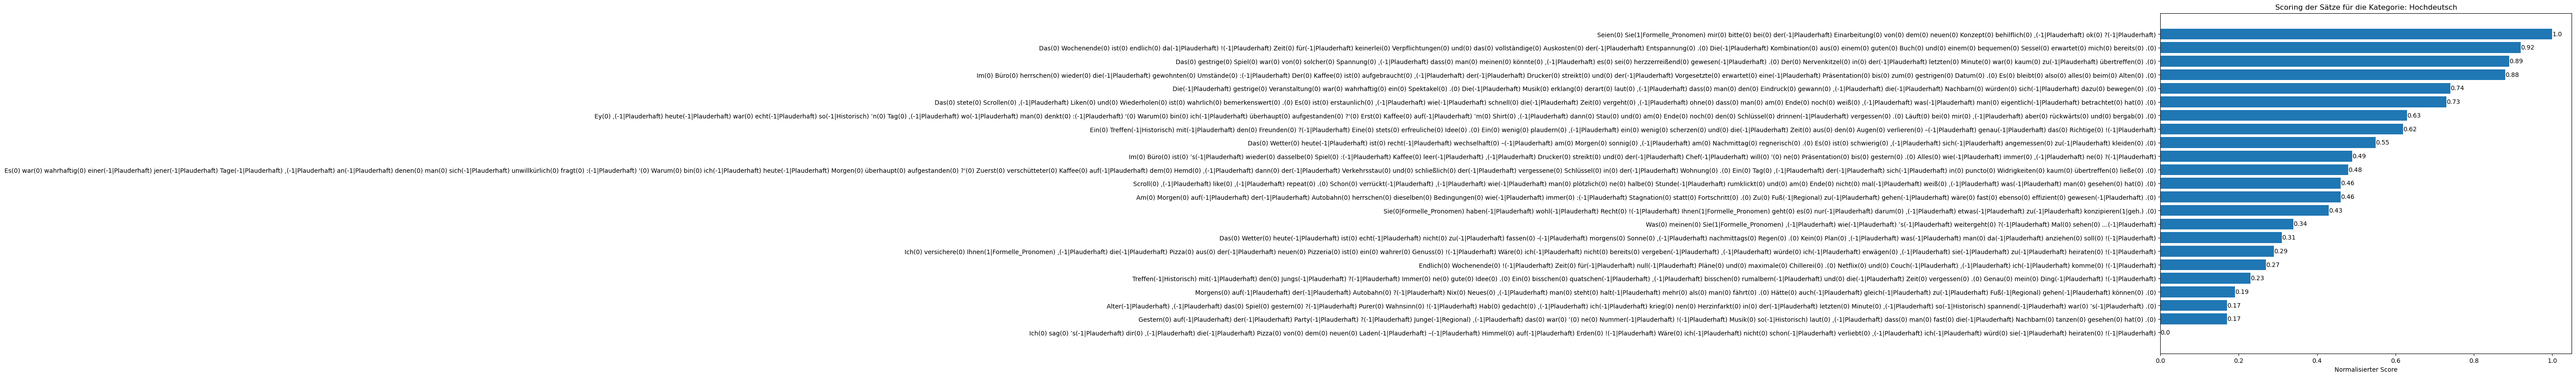

In [38]:
def visualize_custom_scoring(sorted_sentences, category):
    # Extrahiere Sätze und ihre Scores
    sentences = [s[0] for s in sorted_sentences]
    scores = [s[2] for s in sorted_sentences]

    # Plot erstellen
    plt.figure(figsize=(12, min(2 + 0.5 * len(sentences), 10)))  # Dynamische Höhe je nach Satzanzahl
    bars = plt.barh(sentences, scores, align='center')
    plt.xlabel('Normalisierter Score')
    plt.title(f'Scoring der Sätze für die Kategorie: {category}')
    
    # Sortierung Stärkster bis schwächster Vertreter
    plt.gca().invert_yaxis()

    # Score-Werte auf Balken schreiben
    for bar, score in zip(bars, scores):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{score}', va='center', ha='left', fontsize=10)

    plt.tight_layout()
    plt.show()

# Analysiere / sortiere Bsp.-Sätze
sorted_sentences = custom_scoring_analysis(example_sentences, category_to_analyze)

# Visualisierung aufrufen
visualize_custom_scoring(sorted_sentences, category_to_analyze)


# Vektorisierung des Wortschatzes der Bücher mittels TF-IDF

Lade Bücherliste

In [ ]:
dataset_path = '../data/results.array.json'

with open(dataset_path, 'r', encoding='utf-8') as f:
    genres_data = json.load(f)

Datenvorbereitung

In [ ]:
# Sätze pro Genre zu einem Text zusammenfassen
genres_texts = {genre: " ".join(sentences) for genre, sentences in genres_data.items()}

# Genre-Namen und Textinhalte extrahieren
genre_names = list(genres_texts.keys())
genre_texts = list(genres_texts.values())

Vektorisierung

In [ ]:
# TF-IDF-Vektorisierung
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(genre_texts)

# Cosinus-Ähnlichkeiten
cosine_similarities = cosine_similarity(tfidf_matrix)

# Ergebnis als DataFrame
cosine_df = pd.DataFrame(cosine_similarities, index=genre_names, columns=genre_names)
print("Cosinus-Ähnlichkeit zwischen den Genres:")
display(cosine_df)

Cosinus-Ähnlichkeit zwischen den Genres:


,nightmarish,positive,real-time,timely,uplifting,witty,whimsical,visionary,versatile,varied,...,authentic,assertive,analytical,amusing,agenda-driven,adventurous,advanced,addictive,action-packed,academic
nightmarish,1.000000,0.628234,0.688311,0.621456,0.535734,0.175694,0.568591,0.623105,0.698270,0.708903,...,0.717157,0.620010,0.579543,0.601785,0.610954,0.615434,0.641474,0.614623,0.652962,0.623401
positive,0.628234,1.000000,0.791062,0.628937,0.766768,0.204623,0.534849,0.732415,0.837628,0.797659,...,0.777609,0.814054,0.613656,0.588462,0.703692,0.594522,0.718401,0.826931,0.647258,0.677598
real-time,0.688311,0.791062,1.000000,0.903930,0.647125,0.195914,0.560058,0.860597,0.919134,0.893045,...,0.863919,0.857537,0.793529,0.680482,0.888973,0.713634,0.873574,0.761832,0.770411,0.851862
timely,0.621456,0.628937,0.903930,1.000000,0.528018,0.152086,0.507079,0.825523,0.811101,0.796035,...,0.775762,0.750348,0.775767,0.629484,0.851107,0.660763,0.841785,0.635236,0.711793,0.829553
uplifting,0.535734,0.766768,0.647125,0.528018,1.000000,0.255204,0.440663,0.608670,0.643573,0.626809,...,0.647834,0.647804,0.498422,0.486576,0.596529,0.545285,0.572287,0.804204,0.530251,0.539690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
adventurous,0.615434,0.594522,0.713634,0.660763,0.545285,0.172147,0.574022,0.643600,0.732627,0.753391,...,0.753100,0.622616,0.616910,0.611746,0.655640,1.000000,0.678055,0.655267,0.685449,0.665468
advanced,0.641474,0.718401,0.873574,0.841785,0.572287,0.141409,0.532887,0.862057,0.881906,0.853588,...,0.815613,0.835519,0.824792,0.605462,0.829690,0.678055,1.000000,0.675540,0.741445,0.967399
addictive,0.614623,0.826931,0.761832,0.635236,0.804204,0.241178,0.531903,0.692597,0.776708,0.754555,...,0.758457,0.713225,0.596365,0.606194,0.689491,0.655267,0.675540,1.000000,0.628200,0.647742
action-packed,0.652962,0.647258,0.770411,0.711793,0.530251,0.156250,0.567624,0.687203,0.776815,0.788018,...,0.796770,0.683543,0.656290,0.620288,0.702347,0.685449,0.741445,0.628200,1.000000,0.718357


Visualisierung der Top 10 cosinus-ähnlichsten Genre-Paare

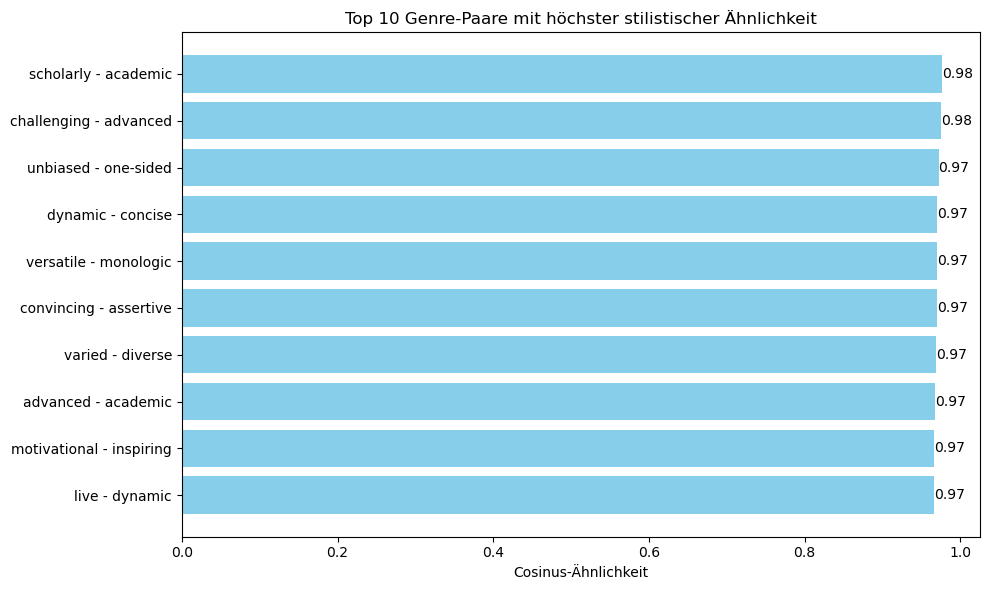

In [ ]:
# Extrahiere oberen Dreieckswerte der Cosinus-Ähnlichkeitsmatrix ohne Diagonaleinträge
similarities = []
for i in range(len(genre_names)):
    for j in range(i + 1, len(genre_names)):
        similarities.append((cosine_df.iloc[i, j], genre_names[i], genre_names[j]))

# Sortiere Ähnlichkeiten absteigend & wähle Top 10 Paare aus
top_10_similarities = sorted(similarities, key=lambda x: x[0], reverse=True)[:10]

# Paare und ihre Ähnlichkeiten extrahieren
top_10_scores = [pair[0] for pair in top_10_similarities]
top_10_pairs = [f"{pair[1]} - {pair[2]}" for pair in top_10_similarities]

# Visualisierung der Top 10 Paare mit der höchsten Ähnlichkeit
plt.figure(figsize=(10, 6))
bars = plt.barh(top_10_pairs, top_10_scores, color='skyblue')
plt.xlabel('Cosinus-Ähnlichkeit')
plt.title('Top 10 Genre-Paare mit höchster stilistischer Ähnlichkeit')
plt.gca().invert_yaxis()

# Score-Werte auf die Balken schreiben
for bar, score in zip(bars, top_10_scores):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{score:.2f}', va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()
